In [72]:
import numpy as np
import matplotlib.pyplot as plt
from classiq import *
from classiq.execution import ExecutionSession
from tqdm import tqdm
np.random.seed(0)  # Please don't change

# Define the 2D Hamiltonian
HAMILTONIAN = [
    PauliTerm([Pauli.I, Pauli.I], -1.0523),
    PauliTerm([Pauli.I, Pauli.Z], 0.3979),
    PauliTerm([Pauli.Z, Pauli.I], -0.3979),
    PauliTerm([Pauli.Z, Pauli.Z], -0.0112),
    PauliTerm([Pauli.X, Pauli.X], 0.1809),
]

In [73]:
matrix_H = hamiltonian_to_matrix(HAMILTONIAN)
print(matrix_H)
np.linalg.eigh(matrix_H)

[[-1.0635+0.j  0.    +0.j  0.    +0.j  0.1809+0.j]
 [ 0.    +0.j -1.8369+0.j  0.1809+0.j  0.    +0.j]
 [ 0.    +0.j  0.1809+0.j -0.2453+0.j  0.    +0.j]
 [ 0.1809+0.j  0.    +0.j  0.    +0.j -1.0635+0.j]]


EighResult(eigenvalues=array([-1.85720199, -1.2444    , -0.8826    , -0.22499801]), eigenvectors=array([[ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,
         0.        +0.j],
       [-0.99376135+0.j,  0.        +0.j,  0.        +0.j,
        -0.11152752+0.j],
       [ 0.11152752+0.j,  0.        +0.j,  0.        +0.j,
        -0.99376135+0.j],
       [ 0.        +0.j, -0.70710678+0.j, -0.70710678+0.j,
         0.        +0.j]]))

In [74]:
aux_number = 8

@qfunc
def prep_ancilla(q: QBit) -> None:
    X(target=q)
    H(target=q)
    
    
@qfunc
def prep_target(qba: QArray[QBit]) -> None:
    H(qba[0])
    repeat(
        count=qba.len - 1,
        iteration=lambda index: CX(ctrl=qba[index], target=qba[index + 1]),
    )
    

@qfunc
def trotter(qba: QArray[QBit], t: CReal) -> None:

    suzuki_trotter(
        HAMILTONIAN,
        evolution_coefficient=t,
        order=1,
        repetitions=30,
        qbv=qba
        )


@qfunc
def main(aux: Output[QArray[QBit]], E: CReal, t: CArray[CReal, aux_number]) -> None:
  global aux_number
  
  allocate(aux_number, aux)

  repeat(aux.len, lambda i: prep_ancilla(aux[i]))

  target = QArray("target")

  allocate(2, target)
  
  X(target[0])
  X(target[1])
    
  for i in range(aux_number):
    control(aux[i], lambda: trotter(target, t[i]))

  for i in range(aux_number):
    PHASE(target = aux[i], theta=E*t[i])

  for i in range(aux_number):
    H(aux[i])

In [75]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/5f6cf79d-ec55-4e05-919f-341daeccd48f?version=0.59.0


In [ ]:
execution_session = ExecutionSession(qprog)
E_vals = np.linspace(-2, 0, 40)

all_p = []
t = list(np.random.normal(size = aux_number, scale = 9))


for E in tqdm(E_vals):
    sample_result = execution_session.sample({"E": E, "t": t})
    counts = sample_result.counts
    states = list(counts.keys())
    shots = list(counts.values())

    p = [i[1]/2048 for i in zip(states, shots) if i[0] == "1"*aux_number]
    if not p:
        p = [0]
    all_p.append(p)


  0%|          | 0/40 [00:00<?, ?it/s]

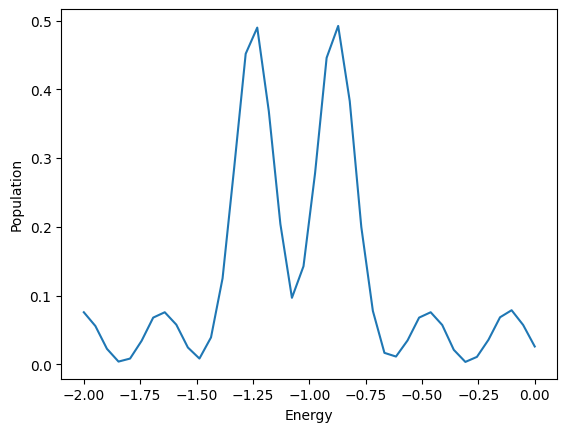

In [64]:
plt.plot(E_vals, all_p)
plt.xlabel("Energy")
plt.ylabel("Population")
plt.show()
#[-1.85720199, -1.2444    , -0.8826    , -0.22499801]